<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/SL_Policy_Training_DH1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/OTHELLO

/content/drive/MyDrive/OTHELLO


In [ ]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from tqdm.notebook import tqdm
import copy
from torch.utils.data import Dataset, DataLoader
import torch

from torch.nn import Conv2d, Linear, ReLU, Dropout
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold

from torch.optim import Adam
from sklearn.metrics import accuracy_score

import matplotlib.patches as pat
import seaborn as sns

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(77)

# Datset

In [ ]:
#DEBUG = True

#data = pd.read_csv('Othello_Kihu.txt', header=None, sep=' ')
#data = data[data[64]!=0] #石を置けない場合(0, 0)のactionをとるが、データ数が１だけなので除外する
#data.iloc[:, :64] = data.iloc[:, :64].where( data.iloc[:, :64] != 2, -1) # 黒 : -1, 白 : 1, 何もなし : 0　の 8*8 の盤面を持つ　ようにする
#cols = [ i for i in range(64)]
#data.loc[data[66]=='B', cols] = data.loc[data[66]=='B', cols]*-1 # 黒手番の場合、自分と相手を入れ替える　モデルが理解しやすいように
#data = data.drop_duplicates()
#data.to_csv('drop_dups.csv', index=False)
#
#data['unputtable'] = data.apply(lambda x: check( x.iloc[:64].values.reshape(8,8) )==[], axis=1)
#data.to_csv('drop_dup2.csv', index=False)
#data = data[data.unputtable != True]
#data = data.iloc[:, :68]
#data.to_csv('drop_dup3.csv', index=False)
#
#if DEBUG:
#    data = data.sample(n=10000)

data = pd.read_csv('drop_dup3.csv')
gc.collect()

print(data.shape)
data.head()

(3337999, 68)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3,W,59
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,W,57
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,-1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,W,55
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,W,53
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,-1,0,0,0,0,-1,-1,-1,0,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,3,W,51


In [ ]:
# 盤面を渡すと、今回置ける場所を返してくれる
# 0が置いてない場所、1が自分の意思がある場所、-1が相手の石が置いてある場所

def check(board): #今回の手番の人が打てる場所をリストアップする
    okeru_list = []
    for x in range(8):
        for y in range(8):
            plc = board[y, x]
            if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                able = octpass([x,y], board) #今回の場所に置いたときひっくり返せる場所をリストアップする
                if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                    okeru_list.append([x,y])
    return okeru_list
  
def octpass(basho, board): #今回置きたい場所を渡したら８方向探索するメソッド
    basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

    if board[basho[1], basho[0]] != 0:
        print('既に石が置かれています')
    else:
        for x in [-1,0,1]:
            for y in [-1,0,1]: #8方向を順に見ていく
                tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                if x == 0 and y == 0:
                    pass #方向がないときはパスする

                for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                    if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                        check_plc = board[basho[1]+y*length, basho[0]+x*length]
                        if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                            break
                        elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                            tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                        elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                            if len(tmp) > 0: #中身がからでない場合のみ
                                basho_list |= set(tmp)
                            break #手を伸ばすのを終了
    
                    else: #もし盤面を飛び出してしまうならpassする
                        pass
    return list(basho_list)

In [ ]:
class OCDataset(Dataset):
    def __init__(self, df, transformer=None):
        super().__init__()
        self.States = df.iloc[:, :64] #盤面
        self.player = df.iloc[:, 66] #W or B
        self.action = 8*(df.iloc[:, 65]-1) + (df.iloc[:, 64]-1) #0-63のどこに置くか
        self.transformer = transformer

    def __len__(self):
        return self.States.shape[0]

    def __getitem__(self, idx):
        state_can = np.zeros((8,8))
        state = self.States.iloc[idx].values.reshape(8,8)
        action = self.action.iloc[idx]
        if self.transformer:
            state, action = self.transformer.transform(state, action)
        #puttables = check(state)
        #for puttable_place in puttables:
        #    state_can[puttable_place[0], puttable_place[1]] = 1 # 現在の手番が石を置ける場所

        state_my = (state == 1).astype(np.uint8) #自分の石の位置
        state_op = (state == -1).astype(np.uint8) #相手の石の位置
        state_on = (state != 0).astype(np.uint8)   # 盤面の石の位置
        states = np.stack( [state_on, state_op, state_my] )

        states = torch.tensor( states, dtype=torch.float32 )
        action = torch.tensor( action, dtype=torch.int64 )

        return states, action, self.player.iloc[idx]

In [ ]:
def rotate90(state, action, p):
    if p > np.random.uniform(0, 1): # 確率pで変換を行う
        n = np.random.choice(3)+1 # 90度の回転を何回行うか　1-3回行う
        state = np.rot90( state, k=n )
        x, y = action%8, action//8
        for _ in range(n):
            x, y = y, -1*x + 7
        action = 8*y+x
    return state, action

def flip(state, action, p):
    if p > np.random.uniform(0, 1): # 確率pで変換を行う
        n = np.random.choice(1) # ランダムでx軸ory軸を選ぶ
        state = np.flip( state, axis=n ) #(y, x)の次元数のためどちらかをランダムで選ぶ
        x, y = action%8, action//8
        if n == 0:
            x, y = x, -1*y+7
        else:
            x, y = -1*x+7, y
        action = 8*y+x
    return state, action

class transformer:
    def __init__(self, p, mode):
        self.p = p
        self.mode = mode

    def transform(self, state, action): 
        if self.mode=='train':  #train以外は何もしない
            state, action = rotate90(state, action, self.p)
            state, action = flip(state, action, self.p)
        return state, action

# Check Dataset

In [ ]:
def plt_img(state, show_num=False):
    fig, axes= plt.subplots(1, 1)
    back_color = np.ones((8,8))*150 #いい緑色を出すための数字笑
    sns.heatmap(back_color, square = True, ax = axes, cmap='Greens', linewidths=0.3, cbar=False, vmin=0,vmax=255)
    for y in range(8):
        for x in range(8):
            st = state[y][x]
            color='k'
            if st != 0:
                if st==-1:
                    fc, ec = 'w', 'k' 
                elif st==1:
                    fc, ec = 'k', 'w'
                    color='w'
                c = pat.Circle(xy = (x+0.5, y+0.5), radius=0.4, fc=fc, ec=ec, fill = True)
                axes.add_artist(c)
            #axes.text(x+0.25, y+0.75, f"({x},{y})", size=8, color=color, fontweight='bold')
            if show_num:
                axes.text(x+0.25, y+0.75, f"{8*y+x}", size=8, color=color, fontweight='bold')
    plt.show()

def plt_heatmap(state, Q_values, show_num=False):
    back_color = F.softmax( Q_values ).detach().numpy().reshape(8,8)
    fig, axes= plt.subplots(1, 1)
    #back_color = np.ones((8,8))*150 #いい緑色を出すための数字笑
    sns.heatmap(back_color, square = True, ax = axes, linewidths=0.3)
    for y in range(8):
        for x in range(8):
            st = state[y][x]
            color='k'
            if st != 0:
                if st==-1:
                    fc, ec = 'w', 'k' 
                elif st==1:
                    fc, ec = 'k', 'w'
                    color='w'
                c = pat.Circle(xy = (x+0.5, y+0.5), radius=0.4, fc=fc, ec=ec, fill = True)
                axes.add_artist(c)
            #axes.text(x+0.25, y+0.75, f"({x},{y})", size=8, color=color, fontweight='bold')
            if show_num:
                axes.text(x+0.25, y+0.75, f"{8*y+x}", size=8, color=color, fontweight='bold')
    plt.show()

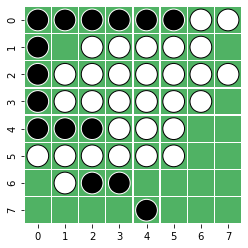

answer : [7, 4]
毎回黒手番です
[[0, 6], [1, 1], [1, 7], [4, 6], [5, 6], [6, 4], [6, 5], [7, 1], [7, 3], [7, 4]]


In [ ]:
data2 = data.sample(5000)

A = OCDataset(data2, transformer=transformer(p=0.5, mode='train'))
B = DataLoader(
    dataset = A,
    batch_size=1000,
    shuffle=False
)
states, actions, color = iter(B).next()

opp = (states[0][1]==1).detach().numpy().astype(np.uint8)*-1
my  = (states[0][2]==1).detach().numpy().astype(np.uint8)
table = opp + my

#table = data.iloc[idx, :64].values.reshape(8,8)
#actions = data.iloc[idx, [64, 65]]
#color = data.iloc[idx, 66]

plt_img(table)

action = actions[0].detach().numpy()
basho = [action%8, action//8]

print("answer :", basho)
#print(color)
print('毎回黒手番です')
print(check(table))

In [ ]:
# 不適切なデータ(置ける場所がないデータ)がないことの確認

TT = []
SS = dict()
IND = []

for i, (S, A, C) in enumerate(zip(states, actions, color)):
    opp = (S[1]==1).detach().numpy().astype(np.uint8)*-1
    my  = (S[2]==1).detach().numpy().astype(np.uint8)
    table = opp + my
    puttables = check(table)
    if [A%8, A//8] not in puttables:
        print("\n",i)
        plt_img(table)
        print("answer :", [A%8, A//8])
        print("puttables :", puttables)
        print("player_color", C)
        print(" ---ただし表示は全て自分を黒にしてます")
        SS[i] = table
        IND.append(i)
    else:
        TT.append(1)
        

print('正答率 :', 100*sum(TT)/len(actions))

正答率 : 100.0


A = OCDataset(data)
B = DataLoader(
    dataset = A,
    batch_size=3,
    shuffle=True
)
states, action, color = iter(B).next()
#print(states[0])

plt.imshow( states[0].numpy().transpose(1,2,0) ,extent=(0,8,0,8), cmap='bwr')
plt.xticks([0,1,2,3,4,5,6,7,8])
# x軸に補助目盛線を設定
plt.grid(which = "major", axis = "x", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)

# y軸に目盛線を設定
plt.grid(which = "major", axis = "y", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)
print(action[0])
print( "y :",action[0]//8 +1 )
print( "x :",action[0]%8 +1 )
print(color[0]) 
print('常に緑の手番ということになってます')
print('赤が今回緑の人が置ける場所')

# Model

In [ ]:
class CNN_Brain(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.1)
        self.drop3 = nn.Dropout(p=0.1)
        self.drop4 = nn.Dropout(p=0.1)

        self.flatten = nn.Flatten()

        self.pi_net = nn.Linear(64*8*8, 64)
        self.pi_act = nn.Softmax(dim=1)

        self.V_net = nn.Linear(64*8*8, 1)
        self.V_act = nn.Tanh()

    def forward(self, x):
        x  = self.relu(self.bn1(self.conv1(x)))
        x  = self.drop1(x)

        x  = self.relu(self.bn2(self.conv2(x)))
        x  = self.drop2(x)

        x  = self.relu(self.bn3(self.conv3(x)))
        x  = self.drop3(x)

        x  = self.relu(self.bn4(self.conv4(x)))
        x  = self.flatten(x)
        x  = self.drop4(x)

        pi = self.pi_act( self.pi_net(x) )
        V  = self.V_act(  self.V_net(x) )
        return pi, V

class CNN_Brain(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.drop1 = nn.Dropout(p=0.2)
        self.drop2 = nn.Dropout(p=0.2)
        self.drop3 = nn.Dropout(p=0.2)
        self.drop4 = nn.Dropout(p=0.2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*8*8, 64)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x  = self.drop1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x  = self.drop2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x  = self.drop3(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x  = self.drop4(x)
        x = F.softmax( self.fc1(x), dim=1 )
        return x, _

# Training

In [ ]:
def get_folds(NUM_FOLDS=5, data=data):
    kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)
    folds = np.ones(data.shape[0])

    for i, (trn_idx, val_idx) in enumerate(kfold.split(data)):
        folds[val_idx] = i
    return folds

def get_loaders(df, folds, n_fold):
    trn_df = df[(folds!=n_fold)]
    val_df = df[(folds==n_fold)]

    trn_dataset = OCDataset(trn_df, transformer=transformer(p=0.5, mode='train'))
    val_dataset = OCDataset(val_df)

    trn_loader = DataLoader(
        dataset = trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    val_loader = DataLoader(
        dataset = val_dataset,
        batch_size = BATCH_SIZE,
        shuffle=False
    )
    return trn_loader, val_loader

In [ ]:
def train_fn(model, optim, trn_loader, metrics, show_bar=False):
    train_loss = 0
    accs = []
    loader = tqdm(trn_loader) if show_bar else trn_loader
    for table, action, _ in loader:
        model.train()
        optim.zero_grad()
        table   = table.to(DEVICE)
        action = action.to(DEVICE)
        pi_value, V_value = model(table)
        loss  = metrics( torch.log(pi_value), action )
        #loss  = metrics( pi_value, action )
        loss.backward()
        optim.step()

        train_loss += loss.cpu().detach().numpy()
        acc  = accuracy_score(action.cpu().detach().numpy(), np.argmax(pi_value.cpu().detach().numpy(), axis=1  ))
        accs.append(acc)
    return train_loss / len(trn_loader), np.mean(accs)

def valid_fn(model, val_loader, metrics, show_bar):
    valid_loss = 0
    accs = []
    loader = tqdm(val_loader) if show_bar else val_loader
    for table, action, _ in  tqdm(val_loader):
        with torch.no_grad():
            model.eval()
            table   = table.to(DEVICE)
            action = action.to(DEVICE)
            pi_value, V_value = model(table)
            loss  = metrics(torch.log(pi_value), action)
            #loss  = metrics( pi_value, action )

            valid_loss += loss.cpu().detach().numpy()
            acc  = accuracy_score(action.cpu().detach().numpy(), np.argmax(pi_value.cpu().detach().numpy(), axis=1  ))
            accs.append(acc)
    return valid_loss/len(val_loader), np.mean(accs)

In [ ]:
data2 = data.sample(5000)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 2048
SHOW_BAR = True

DEVICE = 'cuda:0'
#metrics = nn.CrossEntropyLoss()
metrics = nn.NLLLoss()

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

folds = get_folds(NUM_FOLDS=5, data=data)
trn_loader, val_loader = get_loaders(data, folds, 0)
model = CNN_Brain().to(DEVICE)

#model_path = "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_1_epoch_7.pth"
#model.load_state_dict(torch.load(model_path))
optim = Adam(params=model.parameters(), lr=0.0005)

for epoch in range(EPOCHS):  
    train_loss = 0
    train_loss, train_acc = train_fn(model, optim, trn_loader, metrics, show_bar=SHOW_BAR)
    valid_loss, valid_acc = valid_fn(model, val_loader, metrics, show_bar=SHOW_BAR)

    print("="*30)
    print(f"epoch is {epoch}")
    print('train_loss :', train_loss)
    print('train_acc :', train_acc)
    print('valid_loss :', valid_loss)
    print('valid_acc :', valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    model_path = f"./SL_models/SL_Network_AugDH_epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_path)


epoch is 0
train_loss : 1.8963710906132598
train_acc : 0.3563088520490291
valid_loss : 1.5722466290362773
valid_acc : 0.4444154284892638



epoch is 1
train_loss : 1.607164026129465
train_acc : 0.43311361033701246
valid_loss : 1.4467666814663658
valid_acc : 0.4819892518213191



epoch is 2
train_loss : 1.5140314540980053
train_acc : 0.4612485317165693
valid_loss : 1.37341930310419
valid_acc : 0.5050536689992331



epoch is 3
train_loss : 1.4557899998192407
train_acc : 0.4788264381030584
valid_loss : 1.3310852087348517
valid_acc : 0.5184076279716258



epoch is 4
train_loss : 1.4160431988217348
train_acc : 0.4909161348591907
valid_loss : 1.2983058179083047
valid_acc : 0.5279976155099694



epoch is 5
train_loss : 1.3881973166224415
train_acc : 0.4987966351670503
valid_loss : 1.2779740431557405
valid_acc : 0.5332551404332823



epoch is 6
train_loss : 1.3669317301614152
train_acc : 0.5052129843038164
valid_loss : 1.2606766308012185
valid_acc : 0.538789709547546



epoch is 7
train_loss : 1.349637788406179
train_acc : 0.5102758287644253
valid_loss : 1.2456388393062756
valid_acc : 0.5439184480444785



epoch is 8
train_loss : 1.335889740315683
train_acc : 0.514750968245901
valid_loss : 1.2359799102771503
valid_acc : 0.5471798312883436



epoch is 9
train_loss : 1.3241275782051263
train_acc : 0.5182463548427604
valid_loss : 1.226253583753036
valid_acc : 0.5495885736196319



epoch is 10
train_loss : 1.3146817315758372
train_acc : 0.521202128203134
valid_loss : 1.2212688436537433
valid_acc : 0.5516076735046013



epoch is 11
train_loss : 1.3070610898769706
train_acc : 0.5234278908966218
valid_loss : 1.210820813486181
valid_acc : 0.5544195384394172



epoch is 12
train_loss : 1.3001895727006936
train_acc : 0.5254114479873766
valid_loss : 1.2068976222371763
valid_acc : 0.5550318131710122



epoch is 13
train_loss : 1.2932616325975195
train_acc : 0.5277532183542268
valid_loss : 1.201776917361043
valid_acc : 0.5574275306748466



epoch is 14
train_loss : 1.2883945803152272
train_acc : 0.5293445111464388
valid_loss : 1.1978776641418598
valid_acc : 0.5579571510736197



epoch is 15
train_loss : 1.2830654672501278
train_acc : 0.5306824296683799
valid_loss : 1.1934818808286467
valid_acc : 0.5603846817484662



epoch is 16
train_loss : 1.2788991742521707
train_acc : 0.5325205924238012
valid_loss : 1.1903363469919543
valid_acc : 0.5610802698427914



epoch is 17
train_loss : 1.274576076974898
train_acc : 0.533484804572521
valid_loss : 1.1859012900685972
valid_acc : 0.5627108296587423



epoch is 18
train_loss : 1.2713485551209538
train_acc : 0.5347528917218222
valid_loss : 1.1853290503741774
valid_acc : 0.5626081288343558



epoch is 19
train_loss : 1.2676948145306184
train_acc : 0.5357291013719448
valid_loss : 1.1803114816455023
valid_acc : 0.5648829562883436



epoch is 20
train_loss : 1.2649116796767053
train_acc : 0.5369189914978844
valid_loss : 1.177401515603797
valid_acc : 0.5648371716832822



epoch is 21
train_loss : 1.2616353029488054
train_acc : 0.5373397615448604
valid_loss : 1.1769170995138905
valid_acc : 0.5656675134202453



epoch is 22
train_loss : 1.2594643057855361
train_acc : 0.5385488741165996
valid_loss : 1.1726070913069087
valid_acc : 0.5668482793328221



epoch is 23
train_loss : 1.2573145323552968
train_acc : 0.5392442796575408
valid_loss : 1.1712663517407844
valid_acc : 0.5673576016104295



epoch is 24
train_loss : 1.2551631241853982
train_acc : 0.5399959629371657
valid_loss : 1.1688778166390636
valid_acc : 0.5683714652032208



epoch is 25
train_loss : 1.252745110747273
train_acc : 0.5406105741324512
valid_loss : 1.1677127484163623
valid_acc : 0.5686805502300614



epoch is 26
train_loss : 1.2505434843842969
train_acc : 0.5413640192391517
valid_loss : 1.1669570266103453
valid_acc : 0.5689588885161042



epoch is 27
train_loss : 1.2495975854572343
train_acc : 0.5420498623061893
valid_loss : 1.165008267741993
valid_acc : 0.5692942508627301



epoch is 28
train_loss : 1.2472018579398196
train_acc : 0.5423197294821914
valid_loss : 1.163363997555949
valid_acc : 0.5702789134394172



epoch is 29
train_loss : 1.246679659178652
train_acc : 0.5425382430727737
valid_loss : 1.1604125510695522
valid_acc : 0.5708954299271473


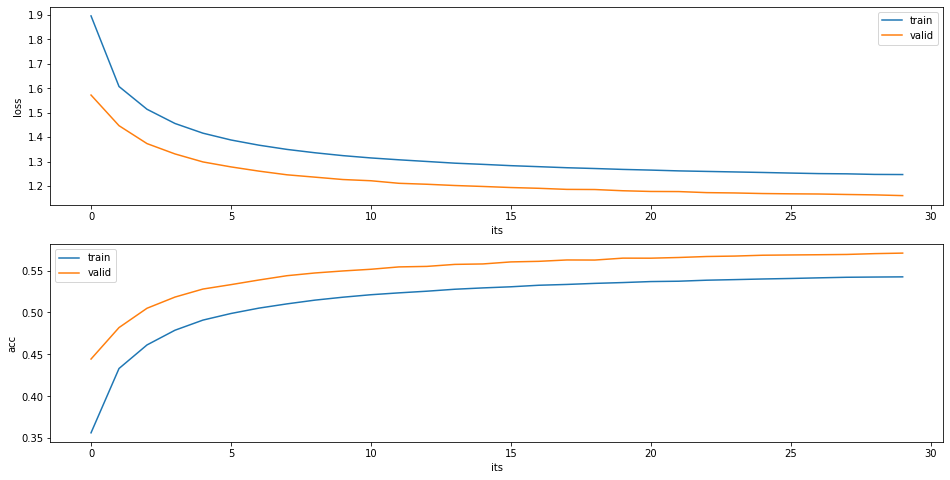

In [ ]:
train_loss_hist = pd.DataFrame(train_losses)
train_acc_hist = pd.DataFrame(train_accs)
val_loss_hist = pd.DataFrame(valid_losses)
val_acc_hist = pd.DataFrame(valid_accs)
fig, axes = plt.subplots(2, 1, figsize = (16, 8))
axes[0].plot(train_loss_hist, label = "train")
axes[0].plot(val_loss_hist, label = "valid")
axes[0].legend(loc = "best")
axes[0].set_xlabel("its")
axes[0].set_ylabel("loss")
axes[1].plot(train_acc_hist, label = "train")
axes[1].plot(val_acc_hist, label = "valid")
axes[1].legend(loc = "best")
axes[1].set_xlabel("its")
axes[1].set_ylabel("acc")
plt.show()